In [1]:
import os
import sys
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.utils.data import DataLoader
import numpy as np
import einops
import wandb
import plotly.express as px
from pathlib import Path
import itertools
import random
from IPython.display import display
import wandb
from jaxtyping import Float, Int, Bool, Shaped, jaxtyped
from typing import Union, Optional, Tuple, Callable, Dict
from collections import Counter
import typeguard
from functools import partial
import copy
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import HookedRootModule, HookPoint
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
from tqdm.notebook import tqdm
from dataclasses import dataclass
from rich import print as rprint
import pandas as pd
import torch
import matplotlib.pyplot as plt


import circuits.eval_sae_as_classifier as eval_sae
import circuits.analysis as analysis
import circuits.eval_board_reconstruction as eval_board_reconstruction
import circuits.get_eval_results as get_eval_results
import circuits.f1_analysis as f1_analysis
import circuits.utils as utils
import circuits.pipeline_config as pipeline_config
from circuits.dictionary_learning.dictionary import AutoEncoder, GatedAutoEncoder, AutoEncoderNew
import common
import chess_utils
import chess
#from plotly_utils import imshow
#from neel_plotly import scatter, line



device = t.device('cuda' if t.cuda.is_available() else 'cpu')
import pickle
with open('meta.pkl', 'rb') as picklefile:
    meta = pickle.load(picklefile)

/opt/conda/envs/chessgpt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
autoencoder = common.load_autoencoder(device)
model = common.load_model(device)
dataset = common.get_dataset(device)
TRAIN_TEST_GAME_SPLIT = 2500

/opt/conda/envs/chessgpt/lib/python3.11/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading statistics aggregation dataset


In [3]:
encoded_inputs_tensor = t.stack([t.tensor(x) for x in dataset['encoded_inputs']]).to(device)
is_check = dataset['board_to_check_state'].squeeze(-1)
is_this_a_dot = (encoded_inputs_tensor == meta['stoi']['.']).to(device)
is_this_a_dot.shape

torch.Size([5000, 256])

In [4]:
aggregation_results = common.get_aggregation_results(1000)
formatted_results = common.get_formatted_results(aggregation_results)
features_for_check_state = common.get_true_feature_indices(formatted_results, "board_to_check_state")
features_for_check_state = features_for_check_state.to(device)

In [5]:
# Get the maximum activations for each feature
max_sae_activations = []
def get_activation(name):
    def hook(model, input, output):
        encoded_activations = autoencoder.encode(output[0]) # batch_size x len_seq x n_features_sae
        print(encoded_activations.shape)
        collapsed = (encoded_activations.max(dim=0).values.max(dim=0).values) # n_features_sae
        max_sae_activations.append(collapsed.unsqueeze(0))
    return hook

t.set_grad_enabled(False)
activation_handle = model.transformer.h[5].register_forward_hook(get_activation(f"resid_stream_{5}"))
num_batches = 100
batch_size = TRAIN_TEST_GAME_SPLIT // num_batches
if device == 'cpu':
    num_batches = 1
    batch_size = 1
    
for i in range(num_batches):
    model(encoded_inputs_tensor[i*batch_size:(i+1)*batch_size])
    t.cuda.empty_cache()
activation_handle.remove()

max_activations = t.concat(max_sae_activations).max(dim=0).values # n_features_sae

torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256, 4096])
torch.Size([50, 256,

In [6]:
#Collect all the activations for the features we care about
relevant_sae_activations = []
def get_activation(name, relevant_features):
    def hook(model, input, output):
        encoded_activations = autoencoder.encode(output[0]) # batch_size x len_seq x n_features_sae
        relevant_sae_activations.append(encoded_activations[:, :, relevant_features])
    return hook

t.set_grad_enabled(False)
activation_handle = model.transformer.h[5].register_forward_hook(get_activation(f"resid_stream_{5}", features_for_check_state))
num_batches = 100
batch_size = len(encoded_inputs_tensor) // num_batches
if device == 'cpu':
    num_batches = 1
    batch_size = 1
for i in range(num_batches):
    model(encoded_inputs_tensor[i*batch_size:(i+1)*batch_size])
    t.cuda.empty_cache()
activation_handle.remove()

In [7]:
all_relevant_sae_activations = t.concat(relevant_sae_activations, dim=0) # batch_size x len_seq x n_check_features_sae
 # batch_size x len_seq
all_relevant_sae_activations.shape, is_this_a_dot.shape


(torch.Size([5000, 256, 30]), torch.Size([5000, 256]))

In [8]:
sae_activations_for_dots = all_relevant_sae_activations * is_this_a_dot.unsqueeze(-1)
inverse_sae_activations_for_dots = (max_activations[features_for_check_state] - all_relevant_sae_activations) * is_this_a_dot.unsqueeze(-1)

In [9]:
sae_activations_for_dots.shape, max_activations.shape

(torch.Size([5000, 256, 30]), torch.Size([4096]))

In [10]:
threshold = 0.2 #We use this since the paper found that 0.2 is the best threshold to use as a classifier, plus gives us slightly more data
indices_of_high_activation = (sae_activations_for_dots > threshold*max_activations[features_for_check_state]).nonzero()
indices_of_low_activation = (inverse_sae_activations_for_dots > 0.99*max_activations[features_for_check_state]).nonzero()
indices_of_high_activation.shape, indices_of_low_activation.shape

(torch.Size([6789, 3]), torch.Size([3608581, 3]))

Note below that we are not finding any activations for feature at index 6. I expect that this is because this feature is just not in the business of handling what comes after a "."

I believe that in the original paper, they limit to max activations over the dataset where the string ends with "." but we are choosing to look at the max activation over every token in the sequence. We do this because we want to have the context that some features are not ever that active after a ".", so we don't want to read too much into random small fluctuations in the activation. For example, below we are looking at feature 6 and seeing that max activation overall is 2.8, but in the context of a "." it is only as high as 0.55, and the next few activations quickly drop off.

If we used the max activation limited to "." data points, we would be expecting some interesting behavior when the activation is in the area of 0.2 to 0.55. This doesn't seem super reasonable to me given that the max activation over the entire dataset is 2.8.

In [11]:
print("Max activation overall", all_relevant_sae_activations[:, :, 6].max().cpu().numpy())
print("Max activations for '.'", (all_relevant_sae_activations * is_this_a_dot.unsqueeze(-1))[:, :, 6].flatten().sort().values.cpu().numpy()[-10:])


Max activation overall 2.8034313
Max activations for '.' [0.2683345  0.29599005 0.31500465 0.31722558 0.32647955 0.3601907
 0.37119764 0.43485147 0.46943176 0.5543358 ]


In [12]:
indices_of_high_activation[:, 2].unique(), features_for_check_state.unique()

(tensor([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], device='cuda:0'),
 tensor([ 167,  228,  410,  614,  706,  746,  765, 1218, 1396, 1610, 1673, 1810,
         1858, 1878, 1969, 2048, 2252, 2303, 2381, 2388, 2533, 2595, 2794, 2960,
         3133, 3168, 3240, 3517, 3814, 3911], device='cuda:0'))

How well do we do if we just use 'is_check' as a classifier for some random feature?

In [13]:
def is_check(board):
    return board.is_check()

i = 5
boards_to_show = 3
low_to_high_data_points = 50

def get_last_space_index(game_string):
    for i in range(len(game_string)-1, -1, -1):
        if game_string[i] == ' ':
            return i
    return -1

def get_activation_data_for_feature(i, low_to_high_data_points, use_train_data):
    if use_train_data:
        filtered_indices_of_high_activation = indices_of_high_activation[indices_of_high_activation[:, 0] < TRAIN_TEST_GAME_SPLIT]
        filtered_indices_of_low_activation = indices_of_low_activation[indices_of_low_activation[:, 0] < TRAIN_TEST_GAME_SPLIT]
    else:
        filtered_indices_of_high_activation = indices_of_high_activation[indices_of_high_activation[:, 0] >= TRAIN_TEST_GAME_SPLIT]
        filtered_indices_of_low_activation = indices_of_low_activation[indices_of_low_activation[:, 0] >= TRAIN_TEST_GAME_SPLIT]
    
    high_activation_indices_for_feature = filtered_indices_of_high_activation[filtered_indices_of_high_activation[:, 2] == i]
    low_activation_indices_for_feature = filtered_indices_of_low_activation[filtered_indices_of_low_activation[:, 2] == i]
    low_activation_indices_for_feature = filtered_indices_of_low_activation[filtered_indices_of_low_activation[:, 1] > 100]
    low_activation_indices_for_feature = low_activation_indices_for_feature[t.randint(0, len(low_activation_indices_for_feature), (low_to_high_data_points * len(high_activation_indices_for_feature), ))]
    return high_activation_indices_for_feature, low_activation_indices_for_feature


def get_counts(indices_for_feature, board_meets_criteria, use_train_data):
    positive_count = 0
    negative_count = 0
    for game_index, position_index, _ in indices_for_feature:
        if use_train_data == (game_index >= TRAIN_TEST_GAME_SPLIT):
            continue
        game_string = dataset['decoded_inputs'][game_index][:position_index]
        last_space_index = get_last_space_index(game_string)
        game_string = dataset['decoded_inputs'][game_index][:last_space_index]
        board = chess_utils.pgn_string_to_board(game_string)
        if board_meets_criteria(board):
            positive_count += 1
        else:
            negative_count += 1
    return positive_count, negative_count

def evaluate_board_metric_criteria_for_feature(i, board_meets_criteria, use_train_data):
    high_activation_indices_for_feature, low_activation_indices_for_feature = get_activation_data_for_feature(i, low_to_high_data_points, use_train_data)

    true_positive_count, false_negative_count = get_counts(high_activation_indices_for_feature, board_meets_criteria, use_train_data)
    false_positive_count, true_negative_count = get_counts(low_activation_indices_for_feature, board_meets_criteria, use_train_data)
    return true_positive_count, false_negative_count, false_positive_count, true_negative_count
    
def get_summary_stats(true_positive_count, false_negative_count, false_positive_count, true_negative_count):
    accuracy = (true_positive_count + true_negative_count) / (true_positive_count + true_negative_count + false_positive_count + false_negative_count)
    precision = true_positive_count / (true_positive_count + false_positive_count)
    recall = true_positive_count / (true_positive_count + false_negative_count)
    f1_score = 2 * (precision * recall)/(precision + recall)
    return accuracy, precision, recall, f1_score

true_positive_count, false_negative_count, false_positive_count, true_negative_count = evaluate_board_metric_criteria_for_feature(i, is_check, use_train_data=True)
accuracy, precision, recall, f1_score = get_summary_stats(true_positive_count, false_negative_count, false_positive_count, true_negative_count)
print(f"Accuracy: {round(accuracy, 3)}")
print(f"Precision: {round(precision, 3)}")
print(f"Recall: {round(recall, 3)}")
print(f"F1 Score: {f1_score}")


Accuracy: 0.973
Precision: 0.42
Recall: 1.0
F1 Score: 0.5916398713826366


Let's try to classify the feature using some simple hardcoded criteria

In [14]:
def split_into_three_categories(a, b):
    if a < b:
        return -1
    else:
        return int(a > b)

def get_attacking_pieces_list(board):
    return [board.piece_at(x).symbol() for x in board.attackers(not board.turn, board.king(board.turn))]

def count_attacking_pieces(board):
    return len(get_attacking_pieces_list(board))

def piece_attacking_king(board):
    output = get_attacking_pieces_list(board)

    if len(output) == 0:
        return None
    return output[0]

def location_of_piece_attacking_king(board):
    output = [chess.square_name(x) for x in board.attackers(not board.turn, board.king(board.turn))]

    if len(output) == 0:
        return None
    return output[0]

def relative_location_of_piece_attacking_king(board):
    king_location = board.king(board.turn)
    attacker_location = location_of_piece_attacking_king(board)
    if attacker_location is None:
        return None
    king_file, king_rank = chess.square_file(king_location), chess.square_rank(king_location)
    attacker_file, attacker_rank = chess.square_file(chess.parse_square(attacker_location)), chess.square_rank(chess.parse_square(attacker_location))
    return attacker_file - king_file, attacker_rank - king_rank

def direction_of_attack(board):
    king_location = board.king(board.turn)
    king_square = chess.square_name(king_location)
    attacker_square = location_of_piece_attacking_king(board)
    if attacker_square is None:
        return None
    index_1 = split_into_three_categories(king_square[0], attacker_square[0])
    index_2 = split_into_three_categories(king_square[1], attacker_square[1])
    if index_1 == index_2 == 0:
        raise Exception("How is the king being attacked by itself?")
    return index_1, index_2

def is_check(board):
    return board.is_check()


criteria_functions = [is_check, piece_attacking_king, location_of_piece_attacking_king, direction_of_attack, count_attacking_pieces, relative_location_of_piece_attacking_king]

def collect_information_about_criteria(high_activation_indices, criteria_functions):
    output_criteria_dict = {x.__name__: [] for x in criteria_functions}
    for game_index, position_index, _ in high_activation_indices:
        if game_index >= TRAIN_TEST_GAME_SPLIT:
            continue
        game_string = dataset['decoded_inputs'][game_index][:position_index]
        last_space_index = get_last_space_index(game_string)
        game_string = dataset['decoded_inputs'][game_index][:last_space_index]
        board = chess_utils.pgn_string_to_board(game_string)
        for criteria_function in criteria_functions:
            output_criteria_dict[criteria_function.__name__].append(criteria_function(board))
    for criterion in criteria_functions:
        output_criteria_dict[criterion.__name__] = Counter(output_criteria_dict[criterion.__name__])
    return output_criteria_dict

        


In [19]:
feature_index_to_information_about_criteria = {}
for i in range(len(features_for_check_state)):
    high_activation_indices_for_feature, low_activation_indices_for_feature = get_activation_data_for_feature(i, low_to_high_data_points, use_train_data=True)
    num_high_activation_indices = len(high_activation_indices_for_feature)
    print(i, "How many high activation indices?", num_high_activation_indices)
    # It's not very interesting if there are less than 20 data points
    if num_high_activation_indices < 20:
        continue
    feature_index_to_information_about_criteria[i] = collect_information_about_criteria(high_activation_indices_for_feature, criteria_functions)
    
    # true_positive_count, false_negative_count = get_counts(high_activation_indices_for_feature, board_meets_criteria)
    # false_positive_count, true_negative_count = get_counts(low_activation_indices_for_feature, board_meets_criteria)

0 How many high activation indices? 65
1 How many high activation indices? 405
2 How many high activation indices? 3
3 How many high activation indices? 126
4 How many high activation indices? 5
5 How many high activation indices? 92
6 How many high activation indices? 0
7 How many high activation indices? 2
8 How many high activation indices? 349
9 How many high activation indices? 59
10 How many high activation indices? 4
11 How many high activation indices? 1
12 How many high activation indices? 13
13 How many high activation indices? 75
14 How many high activation indices? 166
15 How many high activation indices? 43
16 How many high activation indices? 1111
17 How many high activation indices? 1
18 How many high activation indices? 82
19 How many high activation indices? 2
20 How many high activation indices? 3
21 How many high activation indices? 5
22 How many high activation indices? 202
23 How many high activation indices? 7
24 How many high activation indices? 5
25 How many hig

In [20]:
feature_index_to_information_about_criteria.values()

dict_values([{'is_check': Counter({True: 65}), 'piece_attacking_king': Counter({'q': 39, 'b': 20, 'p': 5, 'r': 1}), 'location_of_piece_attacking_king': Counter({'e4': 9, 'g4': 7, 'd5': 7, 'f3': 6, 'h3': 5, 'd3': 5, 'c4': 4, 'g2': 3, 'a6': 3, 'c6': 3, 'b7': 2, 'f5': 2, 'c2': 2, 'b5': 1, 'b2': 1, 'b3': 1, 'd7': 1, 'a3': 1, 'a4': 1, 'h5': 1}), 'direction_of_attack': Counter({(1, -1): 39, (-1, -1): 20, (1, 0): 3, (-1, 0): 3}), 'count_attacking_pieces': Counter({1: 65}), 'relative_location_of_piece_attacking_king': Counter({(-2, 2): 17, (2, 2): 9, (-3, 3): 9, (-4, 4): 7, (3, 3): 7, (1, 1): 4, (-5, 5): 3, (-1, 1): 3, (3, 0): 2, (-5, 0): 1, (2, 0): 1, (-4, 0): 1, (-3, 0): 1})}, {'is_check': Counter({True: 405}), 'piece_attacking_king': Counter({'q': 394, 'r': 11}), 'location_of_piece_attacking_king': Counter({'h4': 36, 'd4': 35, 'e3': 30, 'e5': 23, 'e4': 22, 'b6': 18, 'b4': 18, 'e2': 17, 'g5': 15, 'c5': 13, 'g3': 12, 'f2': 11, 'e6': 10, 'd2': 9, 'f4': 8, 'e1': 8, 'c3': 8, 'h2': 8, 'd5': 8, 'a

In [21]:
feature_index_to_criterion_to_acceptable_keys_dict = {}
threshold_for_including_key = 0.05
threshold_for_including_feature = 0.5

for i, criteria_dict in feature_index_to_information_about_criteria.items():
    criterion_to_acceptable_keys_dict = {}
    for criterion, criterion_results_counter in criteria_dict.items():
        counter_values = list(criterion_results_counter.values())
        data_point_count = sum(counter_values)
        if len(counter_values) == 0 or max(counter_values) < data_point_count * threshold_for_including_feature:
            continue
        acceptable_keys = [x for x in criterion_results_counter.keys() if criterion_results_counter[x]/data_point_count > threshold_for_including_key]
        criterion_to_acceptable_keys_dict[criterion] = acceptable_keys
    if len(criterion_to_acceptable_keys_dict) == 0:
        print(i, criteria_dict)
        continue
    feature_index_to_criterion_to_acceptable_keys_dict[i] = criterion_to_acceptable_keys_dict
print(feature_index_to_criterion_to_acceptable_keys_dict.keys())


dict_keys([0, 1, 3, 5, 8, 9, 13, 14, 15, 16, 18, 22, 25, 26, 29])


In [22]:
baseline_feature_to_counts_dict = {}
custom_feature_to_counts_dict = {}

for i in feature_index_to_criterion_to_acceptable_keys_dict.keys():
    print(i)
    true_positive_count, false_negative_count, false_positive_count, true_negative_count = evaluate_board_metric_criteria_for_feature(i, is_check, use_train_data=False)
    if true_positive_count + true_negative_count + false_positive_count + false_negative_count == 0:
        print("No data points for this feature in the test set")
        continue
    baseline_feature_to_counts_dict[i] = true_positive_count, false_negative_count, false_positive_count, true_negative_count


    custom_criteria_dict = feature_index_to_criterion_to_acceptable_keys_dict[i]
    def custom_criteria(board):
        for criterion_function in criteria_functions:
            if criterion_function.__name__ not in custom_criteria_dict:
                continue
            criterion_value = criterion_function(board)
            if criterion_value not in custom_criteria_dict[criterion_function.__name__]:
                return False
        return True

    true_positive_count, false_negative_count, false_positive_count, true_negative_count = evaluate_board_metric_criteria_for_feature(i, custom_criteria, use_train_data=False)
    custom_feature_to_counts_dict[i] = true_positive_count, false_negative_count, false_positive_count, true_negative_count

    

0
1
3
5
8
9
13
14
15
16
18
22
25
26
29


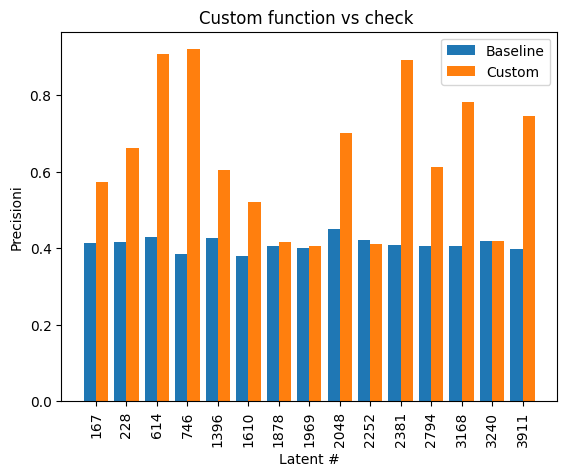

In [23]:
baseline_precision_list = []
custom_precision_list = []
features = []
for i in baseline_feature_to_counts_dict.keys():
    baseline_true_positive_count, baseline_false_negative_count, baseline_false_positive_count, baseline_true_negative_count = baseline_feature_to_counts_dict[i]
    custom_true_positive_count, custom_false_negative_count, custom_false_positive_count, custom_true_negative_count = custom_feature_to_counts_dict[i]
    
    try:
        baseline_accuracy, baseline_precision, baseline_recall, baseline_f1_score = get_summary_stats(baseline_true_positive_count, baseline_false_negative_count, baseline_false_positive_count, baseline_true_negative_count)
        custom_accuracy, custom_precision, custom_recall, custom_f1_score = get_summary_stats(custom_true_positive_count, custom_false_negative_count, custom_false_positive_count, custom_true_negative_count)
        baseline_precision_list.append(baseline_precision)
        custom_precision_list.append(custom_precision)
        if custom_precision < 0.1:
            print(i, features_for_check_state[i].item())
        features.append(features_for_check_state[i].item())
    except ZeroDivisionError:
        print("No data points for this feature in the test set")

X = features
y = baseline_precision_list
z = custom_precision_list
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis - 0.2, y, 0.4, label = 'Baseline') 
plt.bar(X_axis + 0.2, z, 0.4, label = 'Custom') 
  
plt.xticks(X_axis, X, rotation=90) 
plt.xlabel("Latent #") 
plt.ylabel("Precisioni") 
plt.title(f"Custom function vs check ") 
plt.legend() 
plt.savefig(f'plots/bar_chart_custom_function_vs_check_precision.png')
plt.show() 

In [36]:
for i, acceptable_keys in feature_index_to_criterion_to_acceptable_keys_dict.items():
    print(i, features_for_check_state[i].item(), acceptable_keys)

0 167 {'is_check': [True], 'piece_attacking_king': ['q', 'b', 'p'], 'direction_of_attack': [(1, -1), (-1, -1)], 'count_attacking_pieces': [1]}
1 228 {'is_check': [True], 'piece_attacking_king': ['q'], 'count_attacking_pieces': [1]}
3 614 {'is_check': [True], 'piece_attacking_king': ['r', 'q'], 'direction_of_attack': [(0, -1)], 'count_attacking_pieces': [1]}
5 746 {'is_check': [True], 'piece_attacking_king': ['b', 'q'], 'location_of_piece_attacking_king': ['f2', 'h4', 'g3', 'h1'], 'direction_of_attack': [(-1, -1), (-1, 0), (1, -1)], 'count_attacking_pieces': [1]}
8 1396 {'is_check': [True], 'piece_attacking_king': ['q', 'b'], 'direction_of_attack': [(-1, -1), (1, -1)], 'count_attacking_pieces': [1]}
9 1610 {'is_check': [True], 'direction_of_attack': [(1, -1), (0, -1), (-1, -1), (1, 0)], 'count_attacking_pieces': [1]}
13 1878 {'is_check': [True], 'count_attacking_pieces': [1]}
14 1969 {'is_check': [True], 'count_attacking_pieces': [1]}
15 2048 {'is_check': [True], 'direction_of_attack': 

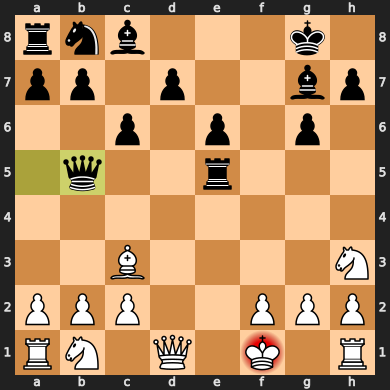

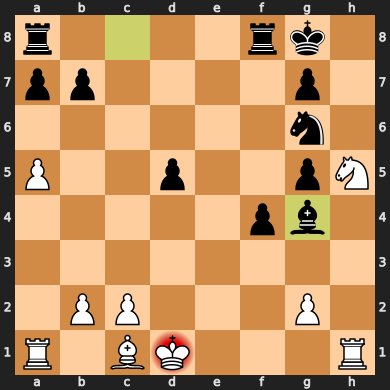

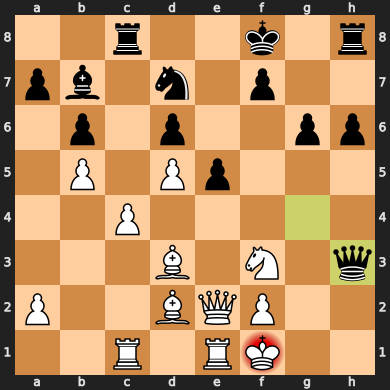

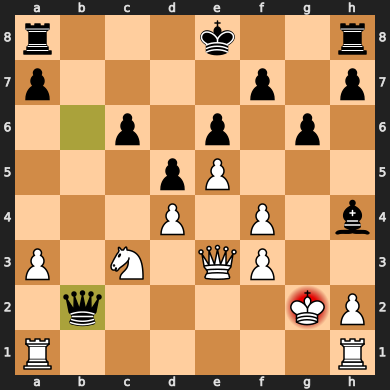

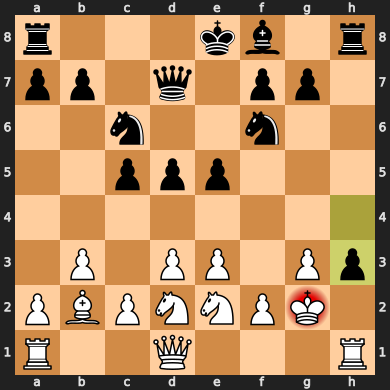

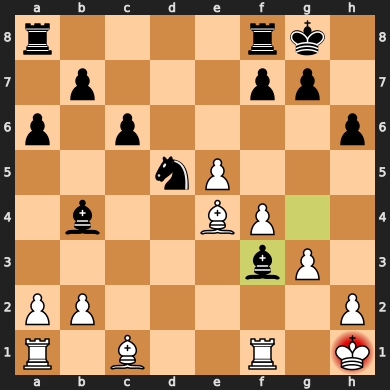

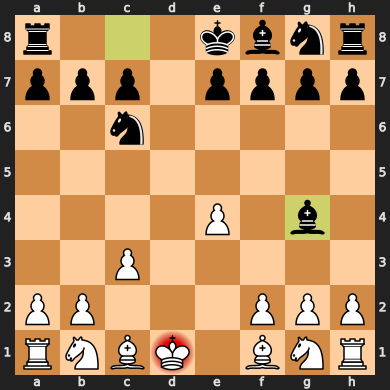

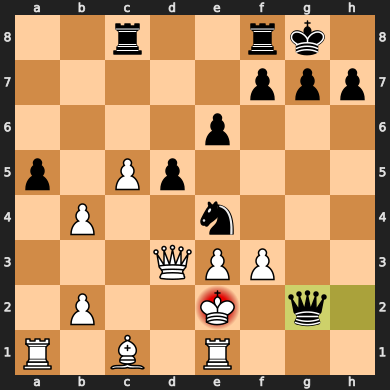

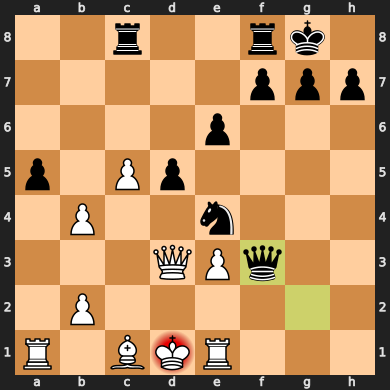

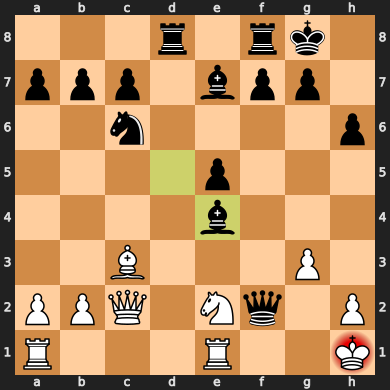

In [52]:
for game_idx, position_idx, _ in indices_of_high_activation[indices_of_high_activation[:, 2] == 0][:10]:
    board = chess_utils.pgn_string_to_board(dataset['decoded_inputs'][game_idx][:position_idx-3])
    display(board)
 


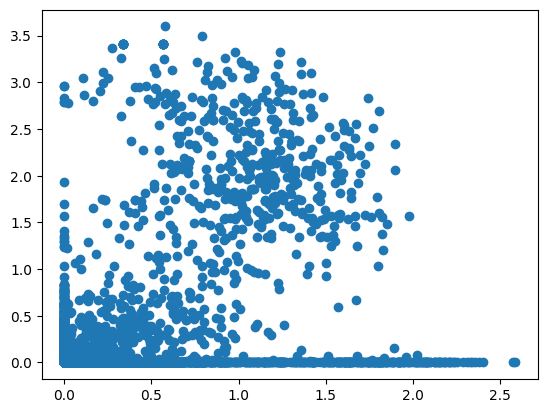

In [45]:
x = all_relevant_sae_activations[:, :, 3]
y =all_relevant_sae_activations[:, :, 18]
plt.scatter(x.cpu().numpy(), y.cpu().numpy())
plt.show()

In [46]:
np.corrcoef(x.cpu().numpy().flatten(), y.cpu().numpy().flatten())

array([[1.        , 0.52435843],
       [0.52435843, 1.        ]])

In [33]:
feature_index_to_information_about_criteria[13]

{'is_check': Counter({True: 75}),
 'piece_attacking_king': Counter({'q': 34, 'r': 27, 'b': 12, 'n': 1, 'p': 1}),
 'location_of_piece_attacking_king': Counter({'e8': 14,
          'b6': 12,
          'c5': 10,
          'd8': 6,
          'c4': 4,
          'd5': 3,
          'e7': 3,
          'a6': 3,
          'c8': 3,
          'e4': 3,
          'd3': 2,
          'd4': 2,
          'f8': 2,
          'h4': 1,
          'f7': 1,
          'g8': 1,
          'g6': 1,
          'b4': 1,
          'd7': 1,
          'c6': 1,
          'f5': 1}),
 'direction_of_attack': Counter({(0, -1): 37, (1, -1): 33, (-1, -1): 5}),
 'count_attacking_pieces': Counter({1: 75}),
 'relative_location_of_piece_attacking_king': Counter({(0, 7): 17,
          (-5, 5): 12,
          (-4, 4): 12,
          (0, 6): 11,
          (-2, 2): 7,
          (0, 5): 3,
          (0, 3): 2,
          (0, 1): 2,
          (1, 1): 2,
          (-1, 1): 1,
          (5, 5): 1,
          (-1, 2): 1,
          (2, 2): 1,
 